In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Reshape
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Reshape, LSTM, Dense, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Reshape, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Layer

In [4]:
def load_images(folder_path, image_size=(128,128)):
    data = []
    labels = []

    label = os.path.basename(folder_path)  

    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):  
            img = cv2.imread(img_path)
            if img is not None:  
                img = cv2.resize(img, image_size)  
                data.append(img)
                labels.append(label)

    return np.array(data), np.array(labels)

dataset_path = r"E:\Dataset\Retinal OCT Dataset\Augmented_1200"

# Load images for each type of chest X-ray
data_AMRD, labels_AMRD = load_images(os.path.join(dataset_path, 'Age-related-Macular-Degeneration-Retinal-OCT-images'))
data_CSR, labels_CSR = load_images(os.path.join(dataset_path, 'Central-serous-retinopathy-retinal-OCT-images'))
data_DR, labels_DR = load_images(os.path.join(dataset_path, 'Diabetic-Retinopathy-Retinal-OCT-Images'))
data_MH, labels_MH = load_images(os.path.join(dataset_path, 'Macular-Hole-Retinal-OCT-images'))
data_NORMAL, labels_NORMAL = load_images(os.path.join(dataset_path, 'Normal-Retinal-OCT-images'))

In [5]:
data_AMRD.shape

(1200, 128, 128, 3)

In [6]:
# Combine data and labels for all tumor types
All_data = np.concatenate([data_AMRD, data_CSR, data_DR,data_MH,data_NORMAL])
All_labels = np.concatenate([labels_AMRD, labels_CSR, labels_DR, labels_MH,labels_NORMAL])

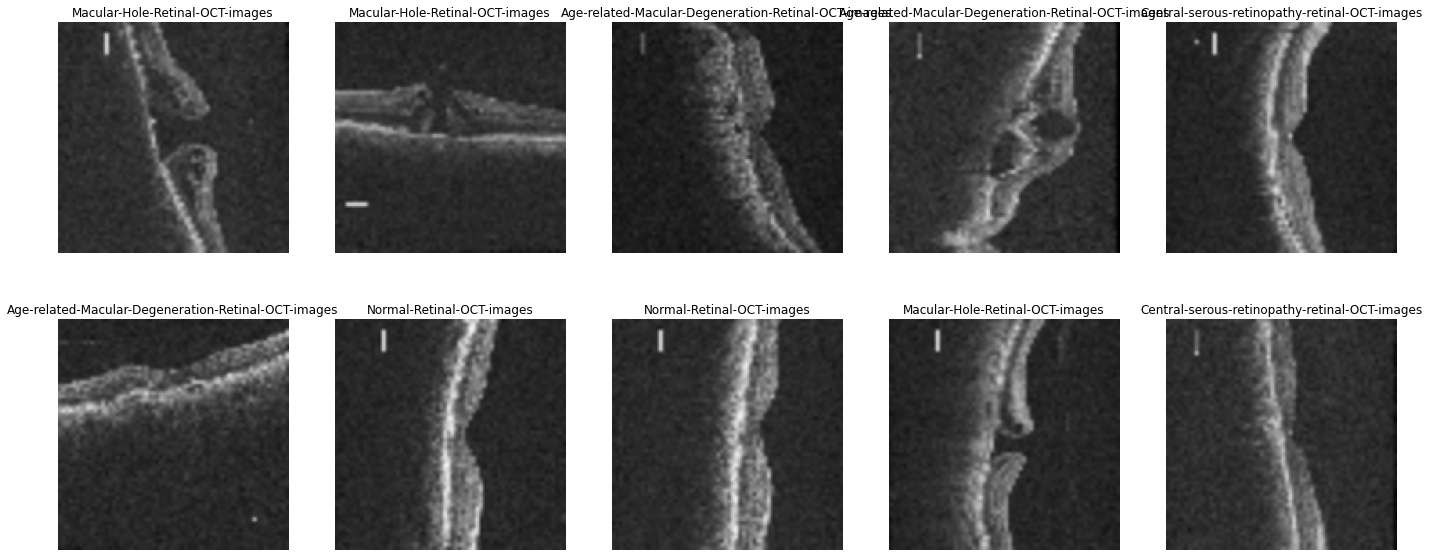

In [13]:
import random
def show_images(images, labels, num_images=10):
    plt.figure(figsize=(24, 10))
    for i in range(num_images):
        index = random.randint(0, len(images) - 1)  # Randomly select an image
        plt.subplot(2, 5, i + 1)
        plt.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
        plt.title(labels[index])
        plt.axis('off')
    plt.show()

# Display 10 random images from the dataset
show_images(All_data, All_labels)

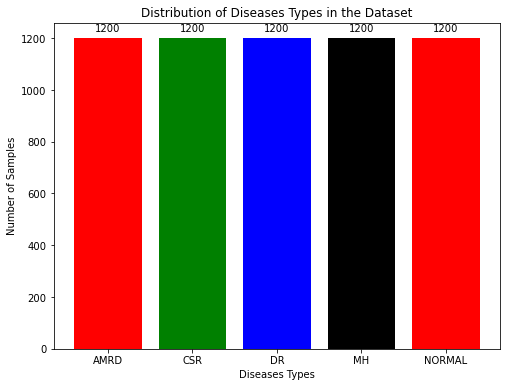

In [5]:
unique_labels, label_counts = np.unique(All_labels, return_counts=True)
plt.figure(figsize=(8, 6))
plt.bar(unique_labels, label_counts, color=['red', 'green', 'blue', 'black'])
plt.xlabel('Diseases Types')
plt.ylabel('Number of Samples')
plt.title('Distribution of Diseases Types in the Dataset')
for i, count in enumerate(label_counts):
    plt.text(i, count + 20, str(count), ha='center', va='bottom')

plt.xticks(unique_labels, ['AMRD', 'CSR', 'DR', 'MH', 'NORMAL' ])
plt.show()

In [6]:
# Normalize Pixel Values
All_data_normalized = All_data / 255.0

In [7]:
# Encode Labels
label_encoder = LabelEncoder()
all_labels_encoded = label_encoder.fit_transform(All_labels)
train_data, test_data, train_labels, test_labels = train_test_split(
    All_data_normalized, all_labels_encoded, test_size=0.15, random_state=42
)

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        et = tf.nn.tanh(tf.tensordot(x, self.W, axes=(2, 0)) + self.b)
        at = tf.nn.softmax(et, axis=1)
        ot = x * at
        return tf.reduce_sum(ot, axis=1)

In [9]:
image_size = (64, 64)
num_classes = 5

In [10]:
from tensorflow.keras.models import Model
inputs = Input(shape=(image_size + (3,)))

# CNN layers with Dropout
x = Conv2D(16, kernel_size=(3, 3), activation="relu")(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)  # Adding Dropout after the first max pooling layer
x = Conv2D(32, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)  # Adding Dropout after the second max pooling layer
x = Flatten()(x)

# Reshape the output to fit the LSTM input
x = Reshape((1, -1))(x)

# Single LSTM layer with Dropout
lstm_out = LSTM(50, return_sequences=True)(x)
lstm_out = Dropout(0.3)(lstm_out)  # Adding Dropout after LSTM layer

# Attention mechanism
attention_output = Attention()(lstm_out)

# Skip connection to final dense layer
combined_output = Add()([attention_output, tf.reduce_sum(lstm_out, axis=1)])

# Final dense layer
outputs = Dense(num_classes, activation="softmax")(combined_output)

# Define the combined model
combined_model = Model(inputs=inputs, outputs=outputs)

# Compile the model
combined_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Callbacks
checkpoint_callback = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min")
early_stopping_callback = EarlyStopping(patience=4, monitor="val_loss", mode="min", restore_best_weights=True)

# Model summary
combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 62, 62, 16)           448       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 31, 31, 16)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 dropout (Dropout)           (None, 31, 31, 16)           0         ['max_pooling2d[0][0]']   

In [11]:
# Train the model with callbacks
history = combined_model.fit(
    train_data,
    train_labels,
    epochs=30,
    batch_size=16,
    validation_split=0.15,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/30
271/271 [==============================] - 13s 40ms/step - loss: 1.1459 - accuracy: 0.5054 - val_loss: 0.8347 - val_accuracy: 0.6183
Epoch 2/30
  1/271 [..............................] - ETA: 11s - loss: 0.6972 - accuracy: 0.6875

C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


271/271 [==============================] - 10s 39ms/step - loss: 0.7166 - accuracy: 0.7061 - val_loss: 0.6240 - val_accuracy: 0.7569
Epoch 3/30
271/271 [==============================] - 10s 38ms/step - loss: 0.5393 - accuracy: 0.7725 - val_loss: 0.4773 - val_accuracy: 0.8052
Epoch 4/30
271/271 [==============================] - 10s 37ms/step - loss: 0.4463 - accuracy: 0.8256 - val_loss: 0.5428 - val_accuracy: 0.8052
Epoch 5/30
271/271 [==============================] - 10s 37ms/step - loss: 0.3500 - accuracy: 0.8648 - val_loss: 0.4354 - val_accuracy: 0.8431
Epoch 6/30
271/271 [==============================] - 10s 37ms/step - loss: 0.2674 - accuracy: 0.9003 - val_loss: 0.3172 - val_accuracy: 0.8771
Epoch 7/30
271/271 [==============================] - 10s 37ms/step - loss: 0.2309 - accuracy: 0.9156 - val_loss: 0.3945 - val_accuracy: 0.8588
Epoch 8/30
271/271 [==============================] - 10s 37ms/step - loss: 0.1880 - accuracy: 0.9338 - val_loss: 0.2287 - val_accuracy: 0.9242
Epo

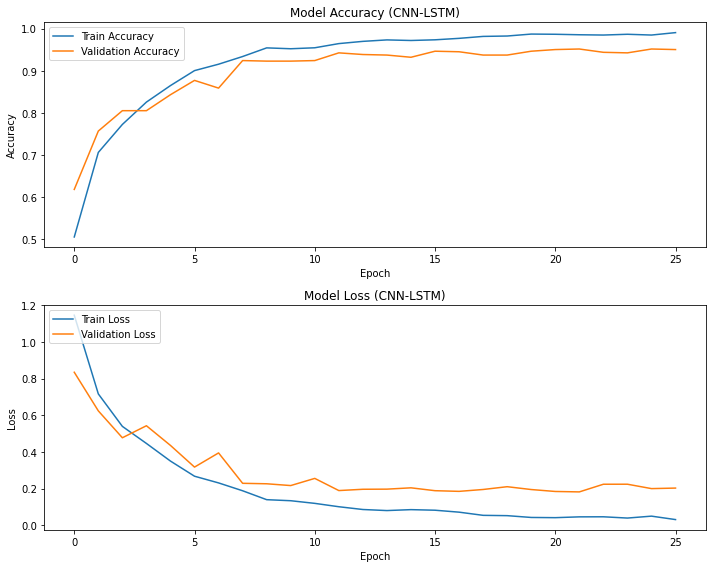

In [12]:
# Create a figure with subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot Accuracy
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy (CNN-LSTM)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='upper left')

# Plot Loss
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss (CNN-LSTM)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [13]:
# Evaluate the model on the test set
test_predictions1 = combined_model.predict(test_data)
test_predictions_classes1 = np.argmax(test_predictions1, axis=1)
CNN_LSTM_class_report1 = classification_report(test_labels, test_predictions_classes1, target_names=label_encoder.classes_)
print("Classification Report:\n", CNN_LSTM_class_report1)

29/29 [==============================] - 1s 16ms/step
Classification Report:
                                                      precision    recall  f1-score   support

Age-related-Macular-Degeneration-Retinal-OCT-images       0.97      1.00      0.98       203
      Central-serous-retinopathy-retinal-OCT-images       0.98      0.92      0.95       194
            Diabetic-Retinopathy-Retinal-OCT-Images       0.89      0.96      0.92       156
                    Macular-Hole-Retinal-OCT-images       0.95      0.94      0.94       186
                          Normal-Retinal-OCT-images       0.98      0.96      0.97       161

                                           accuracy                           0.95       900
                                          macro avg       0.95      0.95      0.95       900
                                       weighted avg       0.96      0.95      0.95       900



In [14]:
accuracy = accuracy_score(test_labels, test_predictions_classes1)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 95.44%


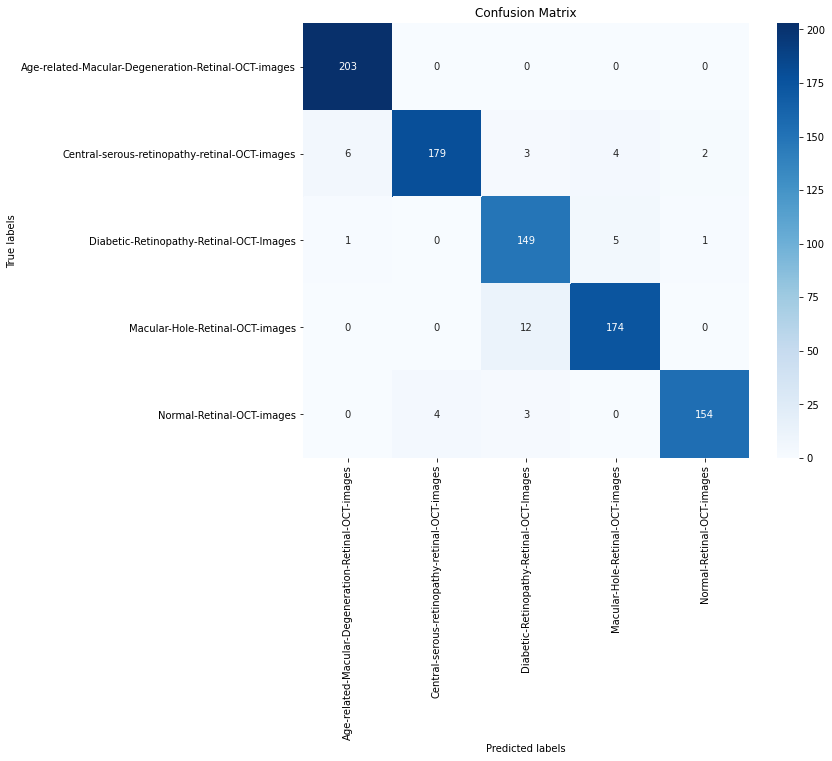

In [15]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions_classes1)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [17]:
#combined_model.save("trained_combined_model_attention.h5")

C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
